In [9]:
pip install yfinance pandas matplotlib ta backtrader

Note: you may need to restart the kernel to use updated packages.


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_32870/123584013.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers=symbol, period="60d", interval="5m")
[*********************100%***********************]  1 of 1 completed

Price                            Close         High          Low         Open  \
Datetime                                                                        
2025-04-11 03:45:00+00:00  3219.000000  3284.050049  3218.000000  3284.050049   
2025-04-11 03:50:00+00:00  3233.649902  3234.449951  3211.100098  3221.399902   
2025-04-11 03:55:00+00:00  3233.449951  3235.000000  3225.000000  3234.000000   
2025-04-11 04:00:00+00:00  3249.000000  3250.000000  3230.300049  3233.800049   
2025-04-11 04:05:00+00:00  3260.350098  3264.949951  3250.149902  3250.149902   

Price                      Volume  
Datetime                           
2025-04-11 03:45:00+00:00       0  
2025-04-11 03:50:00+00:00  360761  
2025-04-11 03:55:00+00:00  268423  
2025-04-11 04:00:00+00:00  241188  
2025-04-11 04:05:00+00:00  243939  


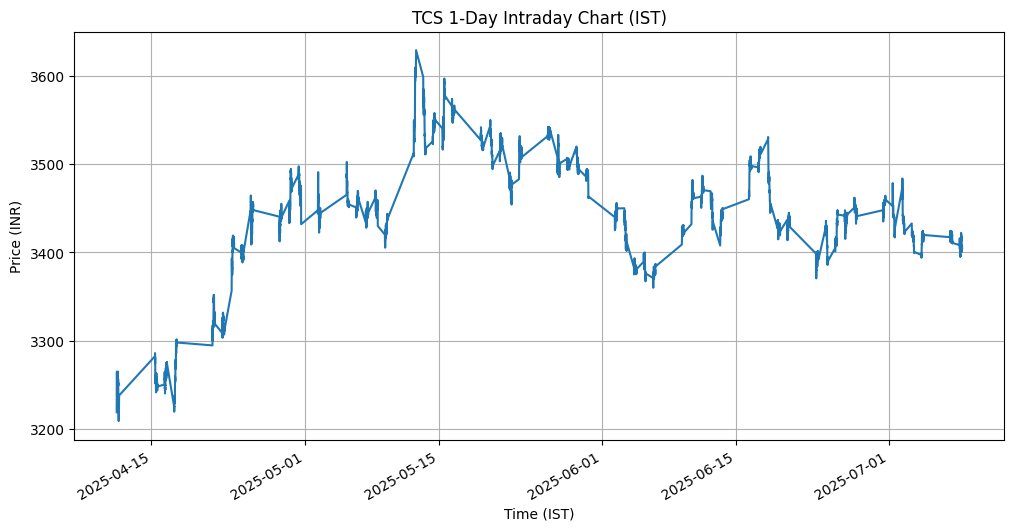

In [2]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Define ticker
symbol = "TCS.NS"

# Download 120-day, 5-minute intraday data
data = yf.download(tickers=symbol, period="60d", interval="5m")
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)
print(data.head())
# If index is already timezone-aware, directly convert to IST
data.index = data.index.tz_convert("Asia/Kolkata")
data.to_csv("tcs_intraday.csv")

# Display data
# print(data.head())

# Plotting
data['Close'].plot(figsize=(12, 6), title="TCS 1-Day Intraday Chart (IST)", ylabel="Price (INR)")
plt.xlabel("Time (IST)")
plt.grid()
plt.show()


In [1]:
import time
import datetime as dt
from zoneinfo import ZoneInfo
import numpy as np
import pandas as pd
import requests
import yfinance as yf

# ── 1. CONFIG ────────────────────────────────────────────────────────────────
CONFIG = {
    "strategy":       "ema_rsi",       # "ema_rsi" or "orb"
    "ema_fast":       9,
    "ema_slow":       21,
    "rsi_period":     14,
    "rsi_oversold":   30,
    "rsi_overbought": 70,
    "orb_window":     15,
    "risk_per_trade": 0.03,            # 3% equity per trade
    "max_daily_loss": 0.05,            # 5% equity per day
    "stop_loss_pct":  0.02,            # 2% adverse move = exit
    # For live, use period="1d"; for backtest, "5d"
    "period":         "5d",
    "interval":       "1m",
    "backtest":       True,           # <-- set False to run continuously live
    "api_base":       "https://api.groww.in/trade/v1",
    "api_key":        "<YOUR_KEY>",
    "api_secret":     "<YOUR_SECRET>",
    "account_id":     "<YOUR_ACCOUNT_ID>",
    "symbol":         "TCS.NS",
}

IST = ZoneInfo("Asia/Kolkata")
MARKET_OPEN  = dt.time(9, 15)
MARKET_CLOSE = dt.time(15, 30)


# ── 2. FETCH & NORMALIZE ─────────────────────────────────────────────────────
def fetch_data() -> pd.DataFrame:
    df = yf.download(
        tickers=CONFIG["symbol"],
        period=CONFIG["period"],
        interval=CONFIG["interval"],
        progress=False
    )
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    df.columns = [c.title() for c in df.columns]
    if df.index.tz is None:
        df.index = df.index.tz_localize("UTC")
    df.index = df.index.tz_convert("Asia/Kolkata")
    df.dropna(subset=["Open", "High", "Low", "Close"], inplace=True)
    # intraday filter (only for live/backtest as 1m bars)
    return df.between_time("09:15", "15:30")


# ── 3. INDICATORS & SIGNALS ─────────────────────────────────────────────────
def add_indicators(df: pd.DataFrame) -> pd.DataFrame:
    df["Ema_Fast"] = df["Close"].ewm(span=CONFIG["ema_fast"], adjust=False).mean()
    df["Ema_Slow"] = df["Close"].ewm(span=CONFIG["ema_slow"], adjust=False).mean()
    delta = df["Close"].diff()
    up, down = delta.clip(lower=0), -delta.clip(upper=0)
    roll_up   = up.rolling(CONFIG["rsi_period"]).mean()
    roll_down = down.rolling(CONFIG["rsi_period"]).mean()
    rs = roll_up / roll_down
    df["Rsi"] = 100 - (100 / (1 + rs))
    n = CONFIG["orb_window"]
    df["Orb_High"] = df["High"].rolling(n).max().shift(n - 1)
    df["Orb_Low"]  = df["Low"].rolling(n).min().shift(n - 1)
    return df

def generate_signals(df: pd.DataFrame) -> pd.Series:
    sig = pd.Series(0, index=df.index, dtype=int)
    if CONFIG["strategy"] == "ema_rsi":
        long_cond = (
            (df["Ema_Fast"] > df["Ema_Slow"]) &
            (df["Rsi"] > CONFIG["rsi_oversold"]) &
            (df["Rsi"].shift(1) <= CONFIG["rsi_oversold"])
        )
        short_cond = (
            (df["Ema_Fast"] < df["Ema_Slow"]) &
            (df["Rsi"] < CONFIG["rsi_overbought"]) &
            (df["Rsi"].shift(1) >= CONFIG["rsi_overbought"])
        )
        sig[long_cond]  =  1
        sig[short_cond] = -1

    elif CONFIG["strategy"] == "orb":
        sig[df["Close"] > df["Orb_High"]] =  1
        sig[df["Close"] < df["Orb_Low"]]  = -1

    return sig


# ── 4. POSITION SIZING & RISK ────────────────────────────────────────────────
def position_size(equity: float, entry_price: float) -> int:
    sl_pct   = CONFIG["stop_loss_pct"]
    risk_cap = CONFIG["risk_per_trade"] * equity
    per_share = entry_price * sl_pct
    return int(risk_cap // per_share)


# ── 5. LIVE ORDER EXECUTION ─────────────────────────────────────────────────
def place_order(symbol: str, qty: int, side: str):
    url = f"{CONFIG['api_base']}/orders"
    headers = {
        "X-API-KEY":    CONFIG["api_key"],
        "X-API-SECRET": CONFIG["api_secret"],
    }
    payload = {
        "account_id":       CONFIG["account_id"],
        "instrument_token": symbol,
        "transaction_type": side,    # "BUY" or "SELL"
        "quantity":         qty,
        "order_type":       "MARKET",
    }
    resp = requests.post(url, json=payload, headers=headers)
    print(f"[{side}] {qty}@{symbol} → {resp.status_code}", resp.json())


# ── 6. CONTINUOUS LIVE LOOP ─────────────────────────────────────────────────
def run_live():
    # switch to today's data only
    CONFIG["period"] = "1d"

    equity      = 100_000
    daily_loss  = 0.0
    position    = 0
    entry_price = 0.0
    last_bar_ts = None

    print("Waiting for market open...")
    while True:
        now = dt.datetime.now(IST)
        if now.time() < MARKET_OPEN:
            time.sleep(30)
            continue
        if now.time() > MARKET_CLOSE:
            print("Market closed. Exiting live loop.")
            break

        # fetch the latest data
        df = fetch_data()
        df = add_indicators(df)
        df["Signal"] = generate_signals(df)

        # get the newest bar's timestamp
        ts = df.index[-1]
        if ts == last_bar_ts:
            # no new bar yet
            time.sleep(5)
            continue
        last_bar_ts = ts

        sig   = int(df.at[ts, "Signal"])
        price = float(df.at[ts, "Close"])

        # max daily-loss guard
        if abs(daily_loss) >= CONFIG["max_daily_loss"] * equity:
            continue

        # ── stop-loss check ───────────────────────────────────────────────
        if position != 0:
            hit_long  = position > 0 and price < entry_price * (1 - CONFIG["stop_loss_pct"])
            hit_short = position < 0 and price > entry_price * (1 + CONFIG["stop_loss_pct"])
            if hit_long or hit_short:
                pnl = (price - entry_price) * position
                equity     += pnl
                daily_loss += -pnl if pnl < 0 else 0
                side = "SELL" if position > 0 else "BUY"
                place_order(CONFIG["symbol"], abs(position), side)
                print(f"SL_EXIT @ {ts.time()}: PnL={pnl:.2f}")
                position = 0

        # ── entry check ───────────────────────────────────────────────────
        if position == 0 and sig != 0:
            qty = position_size(equity, price)
            if qty > 0:
                side = "BUY" if sig > 0 else "SELL"
                place_order(CONFIG["symbol"], qty, side)
                position    = qty * sig
                entry_price = price
                print(f"ENTER {side} {qty}@{price:.2f} @ {ts.time()}")

        # sleep until roughly the next bar
        time.sleep(60 - now.second)

    print("Live session ended.")

# ── 7. BACKTEST (once) ──────────────────────────────────────────────────────
def run_backtest():
    df = fetch_data()
    df = add_indicators(df)
    df["Signal"] = generate_signals(df)

    print("ENTRY signals in backtest:", (df["Signal"] != 0).sum())

    equity      = 100_000
    daily_loss  = 0.0
    position    = 0
    entry_price = 0.0
    prev_date   = None
    log         = []

    for ts in df.index:
        today = ts.date()
        if prev_date is None or today != prev_date:
            daily_loss = 0.0
            prev_date  = today

        sig   = int(df.at[ts, "Signal"])
        price = float(df.at[ts, "Close"])

        if abs(daily_loss) >= CONFIG["max_daily_loss"] * equity:
            continue

        # stop-loss
        if position != 0:
            long_sl  = position>0  and price < entry_price*(1-CONFIG["stop_loss_pct"])
            short_sl = position<0 and price > entry_price*(1+CONFIG["stop_loss_pct"])
            if long_sl or short_sl:
                pnl = (price - entry_price)*position
                equity     += pnl
                daily_loss += -pnl if pnl<0 else 0
                log.append({"timestamp": ts, "action": "SL_EXIT", "pnl": pnl})
                position = 0

        # entry
        if position==0 and sig!=0:
            qty = position_size(equity, price)
            if qty>0:
                position    = qty * sig
                entry_price = price
                log.append({"timestamp": ts, "action": "ENTER", "side": sig, "qty": qty})

        # mtm
        if position!=0:
            mtm = (price - entry_price)*position
            log.append({"timestamp": ts, "action": "MTM", "pnl": mtm})

    # EOD exit
    if position!=0:
        last_ts = df.index[-1]
        last_p = float(df.at[last_ts, "Close"])
        pnl    = (last_p - entry_price)*position
        log.append({"timestamp": last_ts, "action": "EOD_EXIT", "pnl": pnl})

    trades = pd.DataFrame(log).set_index("timestamp")
    total  = trades.loc[trades.action!="MTM","pnl"].sum()
    print(f"Intraday Backtest PnL (incl. EOD exits): {total:.2f}")
    return trades


# ── 8. ENTRY POINT ───────────────────────────────────────────────────────────
if __name__ == "__main__":
    if CONFIG["backtest"]:
        bt = run_backtest()
        bt.to_csv("intraday_bt.csv")
    else:
        run_live()


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_33089/2365920028.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


ENTRY signals in backtest: 3
Intraday Backtest PnL (incl. EOD exits): 1393.20


In [8]:
import datetime as dt
import numpy as np
import pandas as pd
import requests
import yfinance as yf

# ── 1. CONFIG ────────────────────────────────────────────────────────────────
CONFIG = {
    "strategy":       "orb",       # "ema_rsi" or "orb"
    "ema_fast":       9,
    "ema_slow":       21,
    "rsi_period":     14,
    "rsi_oversold":   30,
    "rsi_overbought": 70,
    "orb_window":     15,
    "risk_per_trade": 0.03,            # 3% of equity per trade
    "max_allocation_per_trade":0.20,  # 20% of equity per trade
    "max_daily_loss": 0.05,            # 5% of equity per day
    "stop_loss_pct":  0.02,            # 2% adverse move = exit
    "period":         "5d",            # backtest: last 5 days; live: "1d"
    "interval":       "1m",            # 1-minute bars
    "backtest":       True,            # False → live
    "api_base":       "https://api.groww.in/trade/v1",
    "api_key":        "<YOUR_KEY>",
    "api_secret":     "<YOUR_SECRET>",
    "account_id":     "<YOUR_ACCOUNT_ID>",
    "symbol":         "RELIANCE.NS",
}

# ── 2. FETCH DATA & NORMALIZE ────────────────────────────────────────────────
def fetch_data() -> pd.DataFrame:
    df = yf.download(
        tickers=CONFIG["symbol"],
        period=CONFIG["period"],
        interval=CONFIG["interval"],
        progress=False
    )
    # Flatten MultiIndex if present
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(0)
    # Title-case columns
    df.columns = [c.title() for c in df.columns]
    # Localize/convert to IST
    if df.index.tz is None:
        df.index = df.index.tz_localize("UTC")
    df.index = df.index.tz_convert("Asia/Kolkata")
    df.dropna(subset=["Open","High","Low","Close"], inplace=True)
    # Keep only market hours
    return df.between_time("09:15","15:30")

# ── 3. INDICATORS & SIGNALS ─────────────────────────────────────────────────
def add_indicators(df: pd.DataFrame) -> pd.DataFrame:
    df["Ema_Fast"] = df["Close"].ewm(span=CONFIG["ema_fast"], adjust=False).mean()
    df["Ema_Slow"] = df["Close"].ewm(span=CONFIG["ema_slow"], adjust=False).mean()

    delta = df["Close"].diff()
    up, down = delta.clip(lower=0), -delta.clip(upper=0)
    roll_up   = up.rolling(CONFIG["rsi_period"]).mean()
    roll_down = down.rolling(CONFIG["rsi_period"]).mean()
    rs = roll_up/roll_down
    df["Rsi"] = 100 - (100/(1+rs))

    n = CONFIG["orb_window"]
    df["Orb_High"] = df["High"].rolling(n).max().shift(n-1)
    df["Orb_Low"]  = df["Low"].rolling(n).min().shift(n-1)
    return df

def generate_signals(df: pd.DataFrame) -> pd.Series:
    sig = pd.Series(0, index=df.index, dtype=int)
    if CONFIG["strategy"]=="ema_rsi":
        long_cond = (
            (df["Ema_Fast"]>df["Ema_Slow"]) &
            (df["Rsi"]>CONFIG["rsi_oversold"]) &
            (df["Rsi"].shift(1)<=CONFIG["rsi_oversold"])
        )
        short_cond = (
            (df["Ema_Fast"]<df["Ema_Slow"]) &
            (df["Rsi"]<CONFIG["rsi_overbought"]) &
            (df["Rsi"].shift(1)>=CONFIG["rsi_overbought"])
        )
        sig[long_cond]  = 1
        sig[short_cond] = -1
    else:  # ORB
        sig[df["Close"]>df["Orb_High"]] =  1
        sig[df["Close"]<df["Orb_Low"]]  = -1
    return sig

# ── 4. POSITION SIZING & RISK ────────────────────────────────────────────────
def position_size(equity: float, entry_price: float) -> int:
    # risk‐based qty
    sl_pct    = CONFIG["stop_loss_pct"]
    risk_cap  = CONFIG["risk_per_trade"] * equity
    per_share = entry_price * sl_pct
    qty_risk  = int(risk_cap // per_share)

    # cap by max allocation
    max_alloc = CONFIG["max_allocation_per_trade"] * equity
    qty_cap   = int(max_alloc // entry_price)

    # pick the smaller
    return min(qty_risk, qty_cap)

# ── 5. RUN BACKTEST WITH DAILY EXITS & DAILY PnL ──────────────────────────────
def run_backtest():
    df = fetch_data()
    df = add_indicators(df)
    df["Signal"] = generate_signals(df)

    print("ENTRY signals:", (df["Signal"]!=0).sum())

    equity     = 100_000
    daily_loss = 0.0
    trades     = []

    # iterate day by day
    for date, day_df in df.groupby(df.index.date):
        position    = 0
        entry_price = 0.0

        for ts, row in day_df.iterrows():
            sig   = int(row["Signal"])
            price = float(row["Close"])

            # enforce max daily loss
            if abs(daily_loss) >= CONFIG["max_daily_loss"]*equity:
                break  # stop trading this day

            # stop-loss exit
            if position!=0:
                long_sl  = position>0  and price<entry_price*(1-CONFIG["stop_loss_pct"])
                short_sl = position<0  and price>entry_price*(1+CONFIG["stop_loss_pct"])
                if long_sl or short_sl:
                    pnl = (price-entry_price)*position
                    equity     += pnl
                    daily_loss += -pnl if pnl<0 else 0
                    trades.append({"timestamp": ts, "action": "SL_EXIT", "pnl": pnl})
                    position = 0

            # entry
            if position==0 and sig!=0:
                qty = position_size(equity, price)
                if qty>0:
                    position    = qty*sig
                    entry_price = price
                    trades.append({
                        "timestamp": ts,
                        "action":    "ENTER",
                        "side":      sig,
                        "qty":       qty
                    })

            # mark-to-market (optional)
            if position!=0:
                mtm = (price-entry_price)*position
                trades.append({"timestamp": ts, "action": "MTM", "pnl": mtm})

        # end-of-day exit
        if position!=0:
            last_ts    = day_df.index[-1]
            last_price = float(day_df["Close"].iloc[-1])
            pnl        = (last_price-entry_price)*position
            equity     += pnl
            trades.append({"timestamp": last_ts, "action": "EOD_EXIT", "pnl": pnl})
            position = 0

        # reset daily loss before next day
        daily_loss = 0.0

    # build DataFrame
    trades_df = pd.DataFrame(trades).set_index("timestamp")

    # compute and print daily PnL (excluding MTM)
    realized = trades_df[trades_df.action!="MTM"]
    daily_pnl = realized.groupby(realized.index.date)["pnl"].sum()
    print("\nDaily PnL:")
    for day, pnl in daily_pnl.items():
        print(f"  {day}: {pnl:.2f}")
    print(f"\nTotal backtest PnL: {daily_pnl.sum():.2f}")

    return trades_df

# ── 6. RUN LIVE or BACKTEST ─────────────────────────────────────────────────
if __name__=="__main__":
    if CONFIG["backtest"]:
        df_trades = run_backtest()
        df_trades.to_csv("intraday_backtest.csv")
    else:
        # your run_live() function here
        pass


/var/folders/mn/tx231v5158797chnp22wm9000000gp/T/ipykernel_33089/590889628.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


ENTRY signals: 867

Daily PnL:
  2025-06-30: 178.10
  2025-07-01: 297.70
  2025-07-02: 98.80
  2025-07-03: -22.10
  2025-07-04: 68.90

Total backtest PnL: 621.40
